Ce logbook vise à rassembler des informations et tests préliminaires sur le fichier de synthèse des distributions de photo-z obtenues par Jean-Stéphane.

In [77]:
%matplotlib inline
from matplotlib import pylab as plt
import numpy as np
from scipy import interpolate, integrate

Voici le fichier fourni par Jean-Stéphane. Le chargement est un peu long

In [78]:
filename="./pzdist.txt"
data = np.loadtxt('pzdist.txt')

Une inspection rapide du fichier montre qu'il y a énormément de distributions uniformément nulles. Sauf erreur, seules 8339 pdfs ont un bin non nul, sur un total de 21780 pdfs. Les 3 premières colonnes donnent les indices de zspec, type, et mag, respectivement. Sachant que ces trois arrays sont définies par :

In [80]:
zspec=np.linspace(0.05, 3, 60)
galtype={0:"Ell", 1:"S", 2:"SB"}
mag=np.linspace(-24, -12, 121)
dz=np.linspace(-4.5,4.5,901) #zphot-zs


dz ci-dessus est zphot-zs, et c'est l'abscisse correspondant aux 901 points de pdf qui constituent les autres colonnes. Je prends à présent une pdf particulière, qui exemplifie les problèmes potentiels :

In [81]:
line = 470
example=data[line,3:]
exbin=data[line,:3]

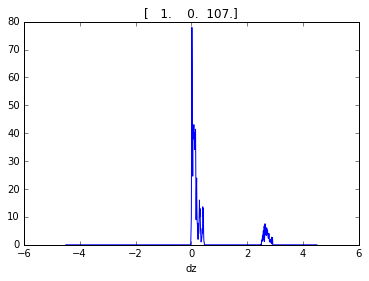

In [82]:
ax=plt.subplot(111)
ax.plot(dz, example)
ax.set_title(exbin)
ax.set_xlabel('dz')

Trois "problèmes" sont visibles :
- le support sur dz [-4.5, 4.5] est défini en dur uniformément pour tous les cas, mais correspond à des cas très défavorables souvent, qui résultent en 0 zphot trouvés par le code Jean-Stéphane. Pour optimiser cela il faudrait avoir un code itératif pas évident à priori.
- le bruit de la distribution est important, et n'est pas du au sous-échantillonnage que J-S exécute ex-post (son histogramme complet est aussi bruité). Ce n'est jamais très agréable quand on s'apprête à interpoller.
- la disjointure des sous-support où la pdf est non nulle est aussi un problème potentiel pour l'interpolation, en particulier dans le cas des splines.

On peut voir ci-dessous un zoom

(-0.1, 3)

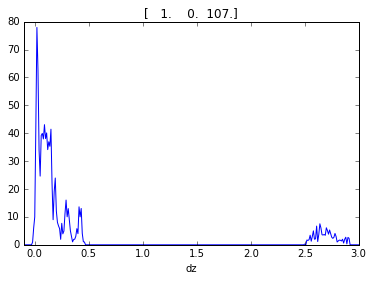

In [83]:
ax=plt.subplot(111)
ax.plot(dz, example)
ax.set_title(exbin)
ax.set_xlabel('dz')
ax.set_xlim(-0.1,3)

Makgré tout, on va tenter un spline d'ordre 3 sur la totalité de l'intervalle en dz :

(-0.3, 3)

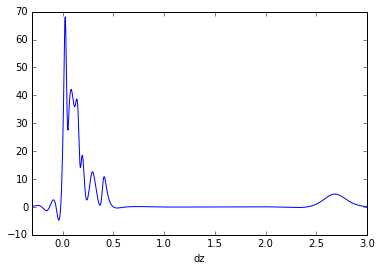

In [85]:
spline=interpolate.UnivariateSpline(dz,example,ext=1, k=3, s=None)
x=np.linspace(dz[0],dz[-1],2000)
ax=plt.subplot(111)
ax.plot(x, spline(x))
ax.set_xlabel('dz')
ax.set_xlim(-0.3,3)

On voit apparaître un problème classique de spline d'ordre 3 et au-dessus, à savoir des oscillations là où la pdf passe rapidement de 0 au pic de probabilité, et donc la fonction de spline induit des valeurs négatives de pdf qu'il faut censurer (hard-thresholding, je ne vois pas de manière plus propre).

Ci-dessous, j'aessaye de masquer les zones nulles pour que le spline ne traite que les intervalles où la pdf est non nulles. C'est probablement ce qu'il faudrait faire, dans la mesure où le lissage résultant est moins aggressif et les oscillations automatiquement disparaissent. Mais le plot ci-dessous montre l'apparition d'un autre problème à traiter, à savoir que le spline interpole entre les deux intervalles de manière aberrante (également un résultat classique du spline). Une interpolation linéaire est exempt de ce problème, mais pour une pdf aussi bruitée ce choix n'est pas très joli. Resterait à extraire les intervalles où pdf!=0 séparément et les traiter conjointement à leur intervalle dz respectifs : c'est faisable mais il faut reprendre entièrement la structure du fichier d'entrée.

(-0.1, 3)

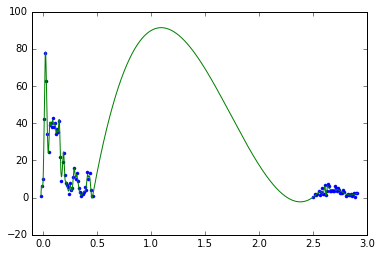

In [44]:
mask=example!=0
masked_dz=dz[mask]
masked_example=example[mask]
plt.plot(masked_dz, masked_example, '.')
masked_spline=interpolate.UnivariateSpline(masked_dz,masked_example,ext=1, k=3, s=None)
masked_x=np.linspace(masked_dz[0],masked_dz[-1],2000)
plt.plot(masked_x, masked_spline(masked_x))
plt.xlim(-0.1,3)

Malgré tout, on tente à présent l'échantillonage, avec une méthode assez brutale pour l'instant.

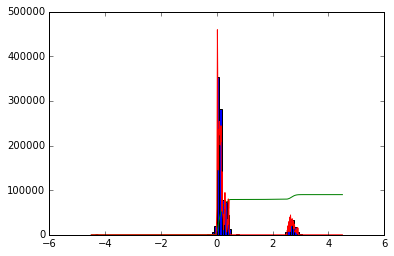

In [98]:
spline=interpolate.UnivariateSpline(dz,example,ext=1, k=3, s=None)
x=np.linspace(dz[0],dz[-1],10000)
y=spline(x)
y[y<0]=0

cumsum=integrate.cumtrapz(y,x, initial=0)
cumsum /= cumsum[-1]
nsample=1000000
u=np.random.random(nsample)
idx=np.searchsorted(cumsum, u)
sampled_z=x[idx]
dummy=plt.hist(sampled_z,100)
plt.plot(x, cumsum*nsample*9./100)
plt.plot(dz, example/example.sum()*nsample*6)

C'est pas trop mal..... mais on ne reproduit pas facilement le détail des sous-pics du pic principal. 

In [72]:
#import scipy.stats as st
#class z_pdf(st.rv_continuous):
#    def __init__(self, name, a=dz[0], b=dz[-1]):
#        st.rv_continuous.__init__(self, name, a, b)
#    def _pdf(self,x):
#        results = spline(x)
#        results[results<0]=0
#        results /= norm
#        return results
#    
#mypdf = z_pdf(name='zdist')
#z=mypdf.rvs(size=1000)
#plt.hist(z, 100)
